# Background #
This notebook goes through the reduction in class for the orion B map

In [1]:
from IPython.display import HTML

HTML('''
// http://lokeshdhakar.com/projects/lightbox2
<link href="./notebook_support/lightbox2-master/dist/css/lightbox.css" rel="stylesheet">

<script src="./notebook_support/lightbox2-master/dist/js/lightbox.js"></script>

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# import commands

In [1]:
## import
from astropy.io import fits

import numpy as np
import glob
import datetime
import pandas as pd
import logging
import os,re
import time
import subprocess
import cygrid
import matplotlib.pyplot as plt
from matplotlib.lines import lineStyles
from astropy.io import fits
from astropy import units as u
import jinja2
import requests

# notebook
from IPython.display import Image, display
from IPython.display import HTML
# astropy
from astropy.io import fits
from astropy import constants as const
from astropy import units as u

plt.rcParams['figure.figsize'] = (15.0, 7.0)

def PrintMessage(message):
    html='''
    <table style="width:100%">
        <tr>
            <td style='text-align:center;vertical-align:middle'>{0}</td>
        </tr>
    </table>
    '''
    display(HTML(html.format(message)))


def Change1dListTo2dList(array, column=2):
    test = []
    test_row = []
    for item in array:
        test_row.append(item)
        if len(test_row)> column-1:
            test.append(test_row)
            test_row = []
    if len(test_row)>0:
        test.append(test_row)
    return test

def DisplayImagesInColumns(images,image_columns=2, gallery_label=""):
    popup_css='''    
    
    <style>
    .thumb img { 
        border:1px solid #000;
        margin:3px;    
        float:left;
    }
    .thumb span { 
        position:fixed;
        visibility:hidden;
    }
    .thumb:hover, .thumb:hover span { 
        visibility:visible;
        z-index:1;
    }

    </style>

    '''
    
    html='''    
    <a href={0} target="_blank">
    <img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    </a>
    '''
    html='''    
    <a href={0}  target="_blank">
    <img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    </a>
    '''
    
    #html='''    
    #<a href={0}  data-lightbox={3} data-title="{0}">
    #<img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    #</a>
    #'''
    
    list2d = Change1dListTo2dList(images, column=image_columns)
    width_percent = (1/float(image_columns))*100.0
    gallery_label = gallery_label.replace(" ","")
    for row in list2d:
        imagesList=popup_css.join( [html.format(image,width_percent-2,time.time(),gallery_label) 
                     for image in row ])
        display(HTML(imagesList))
    return imagesList
   

# Helper Class to run class_cmd_strings and export the images that were created to the notebook
class RunClassScript():
    def __init__(self, cmd, no_output=False, display_images=True, test=False):
        self.cmd = cmd
        self.cmd_file = "/tmp/cmd.class"
        self.cmd_log = "/tmp/cmd.log"
        self.images = [string.split()[1].replace("\"","").replace("//","/") for string in self.cmd.split("\n") if string[0:2] == "ha"]
        if self.cmd.split("\n")[-1].strip() != "exit 0":
            self.cmd = "{}\nexit 0\n".format(self.cmd)
        subprocess.call(["rm", "-rf", "/tmp/cmd.class"])
        fileout = open(self.cmd_file, "w")
        fileout.write(self.cmd)
        fileout.close()
        #output = subprocess.check_output("class -nw @{0}".format(self.cmd_file), shell=True)
        if test:
            print(self.cmd)
        try:
            output = subprocess.check_call("class -nw @{0} > {1}".format(self.cmd_file,self.cmd_log), shell=True)
        except subprocess.CalledProcessError as e:
            print("======================================")
            print("=========== ERROR in class cmd =======")
            print("======================================")
            print("\n")
            print("======================================")
            print("============= INPUT FILE =============")
            print("======================================")
            with open(self.cmd_file, 'r') as fin:
                for line in fin.readlines():
                    if line[0]!=" ":
                        print(line.strip("\n"))
            print("======================================")
            print("========= OUTPUT LOGFILE =============")
            print("======================================")                        
            with open(self.cmd_log, 'r') as fin:
                for line in fin.readlines():
                    if (len(set(line))>1):
                        print(line.strip("\n"))
            raise subprocess.CalledProcessError(e.returncode,e.cmd, e.output)
        if output!=0:
            print(output)
            self.output=output
        #
        if display_images:
            for image in self.images:
                if os.path.exists(image):
                    #display(image, Image(image),width=300,height=300)
                    display(image, Image(image))
def GenerateGIFAnimation(images,gif_filename):
    convert_cmd = "convert -delay 50"\
                  " -loop 0 "\
                  "{0} "\
                  "{1}".format(images,gif_filename)
    os.system(convert_cmd)
    

    from IPython.display import HTML

def download_file(url,local_filename):
    #local_filename = url.split('/')[-1]
    r = requests.get(url)
    f = open(local_filename, 'wb')
    for chunk in r.iter_content(chunk_size=512 * 1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)
    f.close()
    return 

def show_file_content(file, num_lines=10):
    ''' To show class console output '''
    a_file = open(file, "r")
    lines = a_file.readlines()
    last_lines= lines[-num_lines:]
    for line in last_lines:
        print(line)

# Download test data from archive



In [2]:
data_folder = "./tmp/data"


if not os.path.exists(data_folder):
    print("making folder {0}".format(data_folder))
    #os.makedirs(data_folder)
    os.makedirs(data_folder,exist_ok=True)
    
urls = []
#urls.append("https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC4K/20161110_F348/proc/p8486/data/2016-11-10_GR_F348_04_0066_0010505_1900536.9.great.tar")
urls.append("https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC5A/20170208_F371/proc/p4006/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9.great.tar")

for url in urls:
    filename = "{0}/{1}".format(data_folder,url.split('/')[-1])
    if not os.path.exists(filename):
        print("downloading {0} to {1}".format(url, filename))
        download_file(url, filename)
    else:
        print("{1} already downloaded".format(url, filename))
# untar
already_downloaded_great = glob.glob("tmp/data/**/*.great")
#
for url in urls:
    # check for great file
    tar_filename = "{0}/{1}".format(data_folder,url.split('/')[-1])
    filename_great,ext = os.path.splitext(tar_filename)
    full_filename_great,ext = os.path.splitext(os.path.basename(filename_great))
    #
    found = [filename for filename in  already_downloaded_great if full_filename_great in filename]
    if len(found)>0:
        print(" {0} already extracted".format(full_filename_great))
    else:
        print(" {0} extracting".format(full_filename_great))
        #cmd="tar -xvf {0} --wildcards --no-anchored '*Tmb.great' --one-top-level={1}".format(tar_filename,data_folder)
        cmd="tar -xvf {0} --one-top-level={1}".format(tar_filename, data_folder)
        print(cmd)
        output = subprocess.check_call(cmd, shell=True)

./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9.great.tar already downloaded
 2017-02-08_GR_F371_04_0066_0010505_1900536.9 already extracted


#  THE DATA PRODUCTS  IN THE ARCHIVE #
## LEVEL 3 DATA ###

### Level 3 data contains fully calibrated spectra ### 
### produced by the calibration program kalibrate from level 1 data ### 

## 2 **.great** files: ##

- Scientific target spectra in units of Antenna Temperature and additional output spectra.
- Scientific target spectra only, in units of Main Beam Temperature.


### Antenna Temperature file ###

In [3]:
cmd = '''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
list /toc
'''

In [4]:
output = RunClassScript(cmd)

In [106]:
show_file_content('/tmp/cmd.log', 30)

   TAU_IMG      CII_L        SOF-LFAV_4_S          14 (  0.1%)

   TAU_AVG      CII_L        SOF-LFAV_4_S          14 (  0.1%)

   S-H_OBS      CII_L        SOF-LFAV_4_S          12 (  0.1%)

   S-H_FIT      CII_L        SOF-LFAV_4_S          12 (  0.1%)

   SKY-DIFF     CII_L        SOF-LFAV_4_S          11 (  0.1%)

   HOT-COLD     CII_L        SOF-LFAV_4_S           2 (  0.0%)

   TREC (SSB)   CII_L        SOF-LFAV_5_S           3 (  0.0%)

   OMC_CENTER   CII_L        SOF-LFAV_5_S        1008 (  6.4%)

   CAL_SIG      CII_L        SOF-LFAV_5_S          14 (  0.1%)

   CAL_IMG      CII_L        SOF-LFAV_5_S          14 (  0.1%)

   TSYS         CII_L        SOF-LFAV_5_S          14 (  0.1%)

   TAU_SIG      CII_L        SOF-LFAV_5_S          14 (  0.1%)

   TAU_IMG      CII_L        SOF-LFAV_5_S          14 (  0.1%)

   TAU_AVG      CII_L        SOF-LFAV_5_S          14 (  0.1%)

   S-H_OBS      CII_L        SOF-LFAV_5_S          12 (  0.1%)

   S-H_FIT      CII_L        SOF-LFAV_5_

## Additional Spectra ##

- Receiver temperature (TREC)
- System Temperature (TSYS)
- Sky-Hot spectra, Observed and fitted (S-H_OBS, S-H_FIT)
- Opacity (TAU_SIGNAL)

## example TREC spectrum ##

In [5]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
get 15469
pl
ha "./plots/trec.png" /dev png /overwr
'''

'./plots/trec.png'

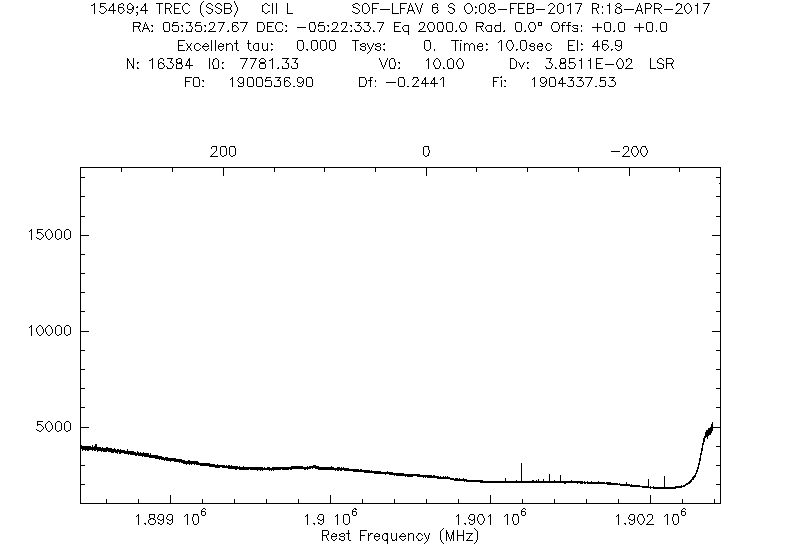

In [109]:
output=RunClassScript(cmd)


## example TSYS spectrum ##

In [6]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
get 15082
pl
ha "./plots/tsys.png" /dev png /overwr
'''

'./plots/tsys.png'

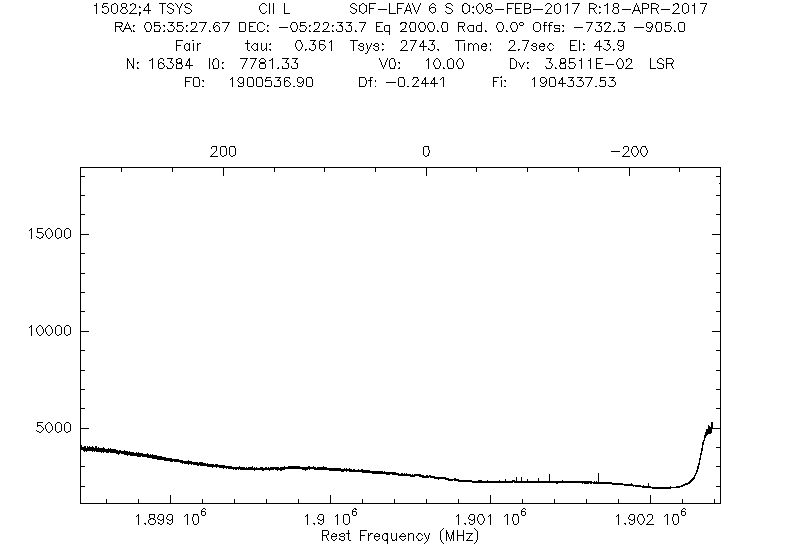

In [7]:
output=RunClassScript(cmd)


## example SKY-HOT_OBS spectra ##

In [8]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find

set mod y -180 -140

get 14993  ! S-H_OBS
pl
get 14995  ! S-H_FIT
pen 1
spec


ha "./plots/s_h.png" /dev png /overwr
'''

'./plots/s_h.png'

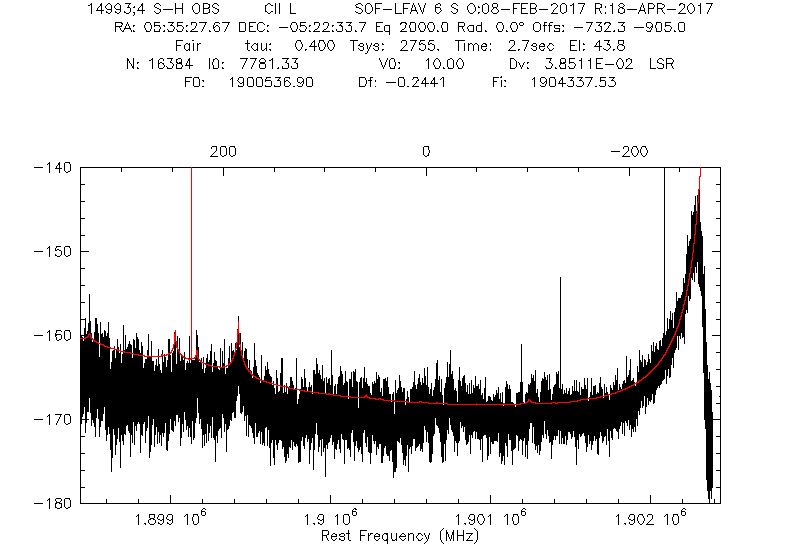

In [113]:
output=RunClassScript(cmd)


## example TAU_SIGNAL spectra ##

In [9]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
get 14990
pl
ha "./plots/tau_signal.png" /dev png /overwr
'''

'./plots/tau_signal.png'

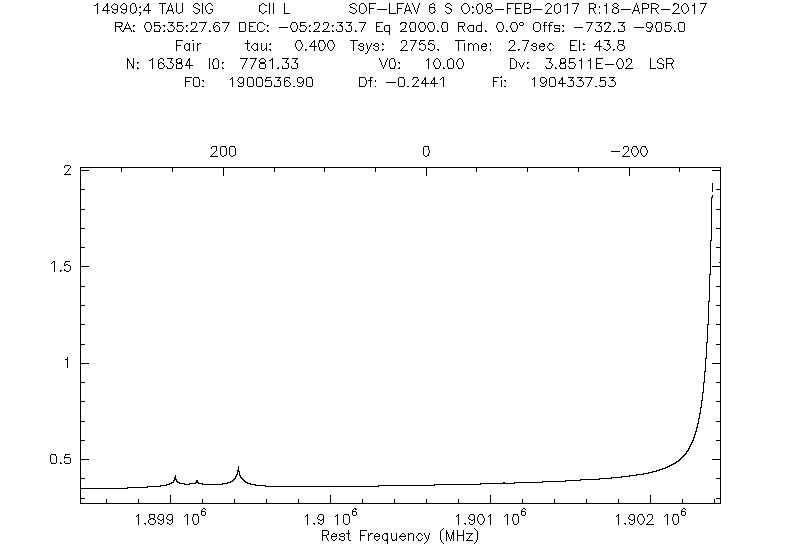

In [10]:
output=RunClassScript(cmd)


# Converting from T<sub>ant</sub> to T<sub>mb</sub> #
## The 2nd level 3  **.great** file ##
- Scientific target spectra only, in units of Main Beam Temperature.


In [11]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
file out "./tmp/data/sofia_school_Tmb.great" single /overwr
set source OMC_CENTER
find

def struct teles_all
list /toc tel /var teles_all

def real mb_values[14]

let mb_values 0.66 0.64 0.67 0.69 0.65 0.66 0.68 0.63 0.64 0.66 0.63 0.64 0.64 0.65 

def int mb_counter
let mb_counter = 1
set unit v
set win 0 20
set align v

for telescope /in teles_all%tele
    set tele 'telescope'
    find
    say 'telescope'
    say 'mb_counter'
    for i 1 to found
        get next
        modify beam_eff mb_values[mb_counter]
        base 1
        wr
    next
    let mb_counter 'mb_counter'+1
next

del /var teles_all

'''

In [11]:
output=RunClassScript(cmd)

# main beam temperature T<sub>mb</sub> file #

In [12]:
cmd='''
file in "./tmp/data/sofia_school_Tmb.great"
find
list /toc
'''

In [13]:
output=RunClassScript(cmd)

In [14]:
show_file_content('/tmp/cmd.log', 100)

GILDAS Version: may20b (13may20 11:32 cest) (x86_64-ubuntu18.04-gfortran) executable tree

W-SIC,  Session is not interactive, SIC EDIT and SIC MEMORY off



 * Welcome to CLASS     



 * Loaded modules

    atm

    sic (J.Pety, S.Bardeau, S.Guilloteau, E.Reynier)

    greg (J.Pety, S.Bardeau, S.Guilloteau, E.Reynier)

    ephem (J.Boissier, F.Gueth, J.Pety)

    class (S.Bardeau, J.Pety, P.Hily-Blant, S.Guilloteau)



 * Loaded extensions

    weeds (S.Maret, P.Hily-Blant, J.Pety, S.Bardeau, E.Reynier)



 * In charge:              J.Pety, S.Bardeau

   Active developers:      S.Guilloteau

   Main past contributors: T.Forveille, P.Hily-Blant, R.Lucas



 * For more information, look at the HELP menu of the CLASS widget



 * Questions? Comments? Bug reports? Mail to: gildas@iram.fr



 * For help, type HELP and/or INPUT at the CLASS prompt



I-INPUT,  ./tmp/data/sofia_school_Tmb.great successfully opened

I-FIND,  14112 observations found

Current index contains:

Number of source

# LEVEL 4 DATA #
## Consists of **.great** files that are a combination of level 3 data products ##
- Averaged spectra (**.great**)
- Datacubes (**.lmv**)

### Averaged Pixels  ###
### Horizontal and Vertical polarizations separated ###

In [15]:
cmd = '''
file in "./tmp/data/sofia_school_Tmb.great"
find

file out "./tmp/data/sofia_school_average_LFA_H_V.great" single /overwr

set def
find
set line CII_L
set teles SOF-LFA*
find
set align v
set nomatch

for i 0 to 6
    set tele SOF-LFAH*'i'*
    find
    average /resample
    wr
next

for i 0 to 6
    set tele SOF-LFAV*'i'*
    find
    average /resample
    wr
next

'''

In [49]:
output=RunClassScript(cmd)

In [50]:
cmd = '''
file in "./tmp/data/sofia_school_average_LFA_H_V.great"
find
list
'''

In [51]:
output=RunClassScript(cmd)

In [52]:
show_file_content("/tmp/cmd.log",14)

 1;1 OMC_CENTER   CII_L        SOF-LFAH_0_S   -187.2   -216.3 Eq 18247 2

 2;1 OMC_CENTER   CII_L        SOF-LFAH_1_S   -177.0   -245.6 Eq 18247 2

 3;1 OMC_CENTER   CII_L        SOF-LFAH_2_S   -206.1   -240.0 Eq 18247 2

 4;1 OMC_CENTER   CII_L        SOF-LFAH_3_S   -217.2   -209.8 Eq 18247 2

 5;1 OMC_CENTER   CII_L        SOF-LFAH_4_S   -195.6   -186.0 Eq 18247 2

 6;1 OMC_CENTER   CII_L        SOF-LFAH_5_S   -164.1   -192.3 Eq 18247 2

 7;1 OMC_CENTER   CII_L        SOF-LFAH_6_S   -156.5   -221.9 Eq 18247 2

 8;1 OMC_CENTER   CII_L        SOF-LFAV_0_S   -183.7   -215.2 Eq 18247 2

 9;1 OMC_CENTER   CII_L        SOF-LFAV_1_S   -174.1   -245.1 Eq 18247 2

10;1 OMC_CENTER   CII_L        SOF-LFAV_2_S   -204.4   -236.3 Eq 18247 2

11;1 OMC_CENTER   CII_L        SOF-LFAV_3_S   -214.3   -206.3 Eq 18247 2

12;1 OMC_CENTER   CII_L        SOF-LFAV_4_S   -195.0   -183.8 Eq 18247 2

13;1 OMC_CENTER   CII_L        SOF-LFAV_5_S   -164.2   -187.8 Eq 18247 2

14;1 OMC_CENTER   CII_L        SOF-LFA

In [57]:
cmd ='''
file in "./tmp/data/sofia_school_average_LFA_H_V.great"
find
list

@plot_group_H_V.gildas -30 40 -30 110
ha "./plots/average_h_v.png" /dev png /overwr
'''

'./plots/average_h_v.png'

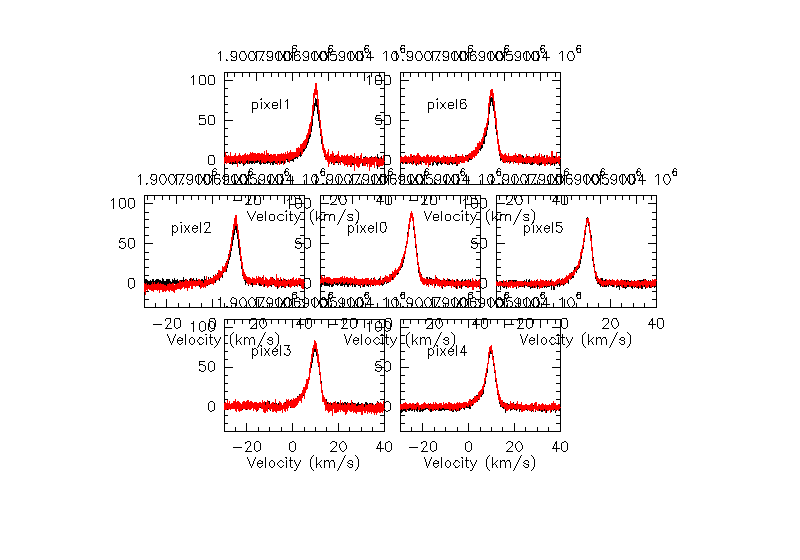

In [58]:
output=RunClassScript(cmd)

### Averaged Pixels  ###
### Horizontal and Vertical polarizations averaged together ###

In [39]:
cmd='''
file in "./tmp/data/sofia_school_Tmb.great"
find

file out "./tmp/data/sofia_school_average_LFA_HVtogether.great" single /overwr

set align v
set nocheck
set telescope SOF-LFA*
find
for i 0 to 6
    set tele SOF-LFA*'i'*
    find
    average /resample
    wr
next

'''

In [40]:
output=RunClassScript(cmd)

In [41]:
cmd='''
file in "./tmp/data/sofia_school_average_LFA_HVtogether.great"
find 
list
'''

In [42]:
output=RunClassScript(cmd)

In [43]:
show_file_content("/tmp/cmd.log")

I-FIND,  7 observations found

Current index contains:

N;V Source       Line         Telescope      Lambda     Beta Sys  Sca Sub

1;1 OMC_CENTER   CII_L        SOF-LFA-_0_S   -187.2   -216.3 Eq 18247 2

2;1 OMC_CENTER   CII_L        SOF-LFA-_1_S   -177.0   -245.6 Eq 18247 2

3;1 OMC_CENTER   CII_L        SOF-LFA-_2_S   -206.1   -240.0 Eq 18247 2

4;1 OMC_CENTER   CII_L        SOF-LFA-_3_S   -217.2   -209.8 Eq 18247 2

5;1 OMC_CENTER   CII_L        SOF-LFA-_4_S   -195.6   -186.0 Eq 18247 2

6;1 OMC_CENTER   CII_L        SOF-LFA-_5_S   -164.1   -192.3 Eq 18247 2

7;1 OMC_CENTER   CII_L        SOF-LFA-_6_S   -156.5   -221.9 Eq 18247 2



In [44]:
cmd ='''
file in "./tmp/data/sofia_school_average_LFA_HVtogether.great"
find
list

set unit v
set mod x -40 40
set mod y -30 130

@plot_group.gildas -40 40 -30 130
ha "./plots/average_h_v.png" /dev png /overwr
'''

'./plots/average_h_v.png'

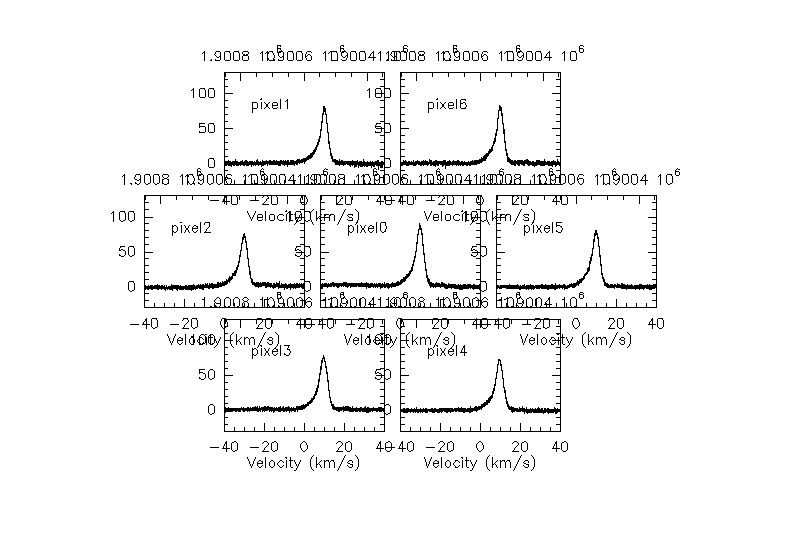

In [45]:
output=RunClassScript(cmd)

# generate average pixel plot

In [59]:
class_script='''
set def
@kosma-init
file in "{filename}"
find
set unit v
set mode x {min_x} {max_x}
set mode y {min_y} {max_y}
set line {line}
set source {source}
set window {window}
set align v

find 

go where
draw t 15 20 {plot_filename} 6
ha "{plot_filename}_go_where.png" /dev png /overwrite

plot_group /group_by telescope
draw t 15 20 {plot_filename} 6
ha "{plot_filename}" /dev png /overwrite
'''

In [60]:
plots_folder = "./plots"
os.makedirs(plots_folder,exist_ok=True)
#
class_cmd = {}
class_cmd['min_x'] = -40
class_cmd['max_x'] = 40
class_cmd['min_y'] = -30
class_cmd['max_y'] = 130
class_cmd['smooth'] = 10
class_cmd['line'] = "CII_L"
class_cmd['source'] = "OMC_CENTER"
class_cmd['window'] = "-20 20"

#already_downloaded_great = glob.glob("tmp/data/**/*.great")
already_downloaded_great = glob.glob("tmp/data/*Tmb.great")
images = []
for class_filename in already_downloaded_great:
    print(class_filename)
    class_cmd["filename"] = os.path.abspath(class_filename)    
    class_cmd["plot_filename"] = "{0}/plot_group_{1}.png".format(plots_folder,os.path.basename(class_filename))
    print(class_cmd["plot_filename"])
    cmd=class_script.format(**class_cmd)
    output = RunClassScript(cmd, no_output=False,display_images=False)
    images.extend(output.images)
message = "Test message"
PrintMessage(message)
DisplayImagesInColumns(images,2,'test_gallery')

tmp/data/sofia_school_Tmb.great
./plots/plot_group_sofia_school_Tmb.great.png


Test message


'    \n    <a href=./plots/plot_group_sofia_school_Tmb.great.png_go_where.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./plots/plot_group_sofia_school_Tmb.great.png_go_where.png?1660915461.4039767\' />\n    </a>\n        \n    \n    <style>\n    .thumb img { \n        border:1px solid #000;\n        margin:3px;    \n        float:left;\n    }\n    .thumb span { \n        position:fixed;\n        visibility:hidden;\n    }\n    .thumb:hover, .thumb:hover span { \n        visibility:visible;\n        z-index:1;\n    }\n\n    </style>\n\n        \n    <a href=./plots/plot_group_sofia_school_Tmb.great.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'./plots/plot_group_sofia_school_Tmb.great.png?1660915461.403984\' />\n    </a>\n    '

# Converting K to Jy #

In [138]:
cmd='''
@jansky 220 11 30
! frequency 220 GHz, beam size in arcsec
'''

In [139]:
output=RunClassScript(cmd)

In [140]:
show_file_content("/tmp/cmd.log", 3)

Wavelength      1.36  mm

K per Jy 0.076552410127295

mJy per K 1.3062946004406E+04



# DATACUBE CREATION IN CLASS #

In [141]:
cmd='''
file in "./tmp/data/sofia_school_Tmb.great"
set tel SOF*

find

file out "./tmp/data/sofia_school_Tmb_base.great" mul /overwrite
for i 1 to found
   get n
   set window  0 20
   base 1
   smooth box 5    
   write
next

file in "./tmp/data/sofia_school_Tmb_base.great"
find
set weight e

table "./tmp/data/sofia_school_map" new /range 0 20 v /nocheck cal

let map%beam 15.1
let map%diam 2.5
let map%cell '-map%beam/4' 'map%beam/4'
let map%reso 'map%beam*1.05'

xy_map "./tmp/data/sofia_school_map"

let name "./tmp/data/sofia_school_map"
let type lmv

let first 40
let last 55

go bit

ha "./plots/datacube_sofia_school.png" /dev png /overwrite

'''

'./plots/datacube_sofia_school.png'

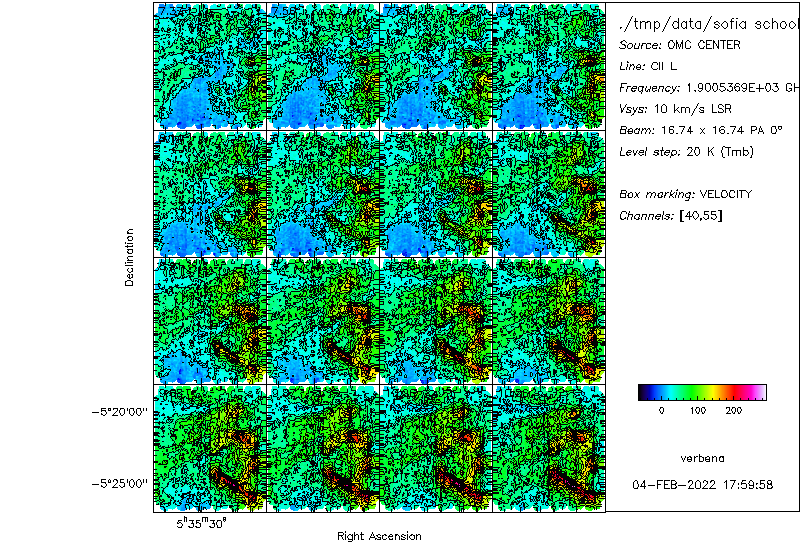

In [142]:
output=RunClassScript(cmd)

In [143]:
cmd='''
let name "./tmp/data/sofia_school_map"
let type lmv
let first 49
let last 49
go bit
ha "./plots/datacube_sofia_school_onechan.png" /dev png /overwrite
'''

'./plots/datacube_sofia_school_onechan.png'

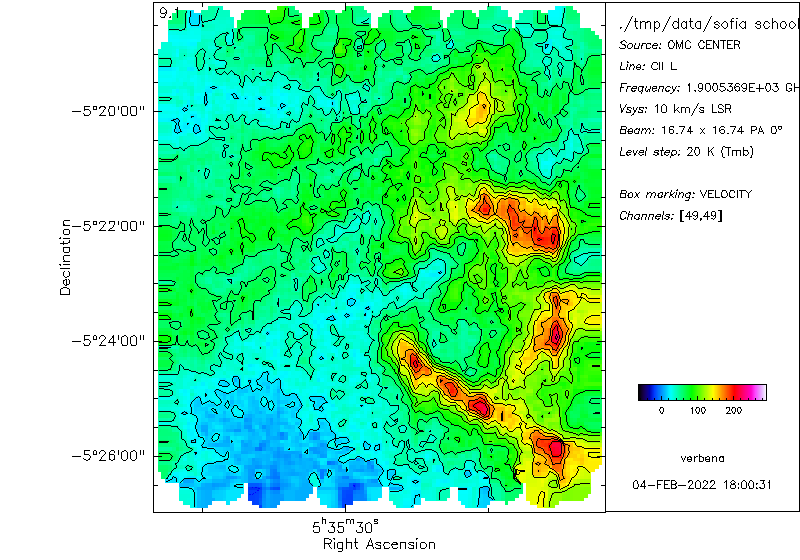

In [144]:
output=RunClassScript(cmd)

# WORKING ON FITS FILES #
## Cygrid  ##

### Creating the fits file from class ###

In [ ]:
cmd='''
set angle sec
file in "./tmp/data/sofia_school_Tmb.great" 
find
fits write "./tmp/data/sofia_school_Tmb_index.fits" /mode index 
'''

In [ ]:
#output=RunClassScript(cmd)

In [99]:
class RawData:
    def __init__(self, fits_file):
        self.fits_file = fits_file
                 
        self.listremdframe = np.empty(0, dtype = int)
        self.lint = False                                                   
        self.rms = False

        with fits.open(self.fits_file) as hdu:
            self.data_fits = hdu[1].data
            self.header = hdu[1].header
        self.data = self._to_numpy()
        self.ra = self.data[:, 3] + self.header['CRVAL2']
        self.dec = self.data[:, 4] + self.header['CRVAL3']
        self.specs = np.nan_to_num(np.array(self.data[:, -1].tolist()))
        self.ra_min, self.ra_max = self.ra.min(), self.ra.max()
        self.dec_min, self.dec_max = self.dec.min(), self.dec.max()

        
    def _to_numpy(self):
        return np.array(self.data_fits.tolist())

    def _to_pandas(self):
        self.data = pd.DataFrame(data=self.data,
            columns=[self.data_fits.columns[i].name for i in range(len(self.data_fits.columns))])
        
    def cygrid_define(self, ra, dec, header, pixsize = 0.0004, kernelsize_sigma = 0.0002):
        '''cygrid params definition'''
        mapcenter = header['CRVAL2'], header['CRVAL3']  
        dnaxis1 = int((ra.max() - ra.min())/pixsize)+1
        dnaxis2 = int((dec.max() - dec.min())/pixsize)+1
        crpix1 = (ra.max() - mapcenter[0])/pixsize
        crpix2 = (mapcenter[1] - dec.min())/pixsize

        kernel_type = 'gauss1d'
        kernel_params = (kernelsize_sigma, )
        kernel_support = 3.0 * kernelsize_sigma
        hpx_maxres = kernelsize_sigma / 2.0

        header_out = {'NAXIS': 3,
              'NAXIS1': dnaxis1,
              'NAXIS2': dnaxis2,
              'NAXIS3': 301,
              'CTYPE1': 'RA---GLS',
              'CTYPE2': 'DEC--GLS',
              'CUNIT1': 'deg',
              'CUNIT2': 'deg',
              'CDELT1': -pixsize,
              'CDELT2': pixsize,
              'CRPIX1': crpix1,
              'CRPIX2': crpix2,
              'CRVAL1': mapcenter[0],
              'CRVAL2': mapcenter[1]
             }
        return header_out, kernel_type, kernel_params, kernel_support, hpx_maxres
    
    
    
    def mygridder(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.to_numpy()
        ra = data[:, 3] + self.header['CRVAL2']
        dec = data[:, 4] + self.header['CRVAL3']
        print( self.header['CRVAL2'],  self.header['CRVAL3'])
        print(ra, dec)
        specs = np.nan_to_num(np.array(data[:, -1].tolist()))
        header_map, kernel_type, kernel_params, kernel_support, hpx_maxres = self.cygrid_define(
                    ra, dec, self.header, pixsize = 0.001, kernelsize_sigma = 0.0005)
        mygridder = cygrid.WcsGrid(header_map)
        mygridder.set_kernel(kernel_type, kernel_params, kernel_support, hpx_maxres)
        mygridder.grid(ra, dec, specs[:, 100: -100])
        gridded_map = mygridder.get_datacube()
        target_wcs = mygridder.get_wcs()
        return gridded_map, target_wcs

    def my3gridder(self):
        self.gridded_map, self.target_wcs =  self.mygridder(self.data)

In [100]:

filename="./tmp/data/sofia_school_Tmb_index.fits"
data= RawData(filename)

/home/verbena/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [101]:
data.my3gridder()

83.865292 -5.376028
[83.81328352389168 83.81328352389168 83.81328352389168 ...
 83.92510250431728 83.92510250431728 83.92510250431728] [-5.436108103576183 -5.4346636595158575 -5.433219215455532 ...
 -5.319770252886295 -5.3183258088259695 -5.316881364765644]


/home/verbena/.local/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


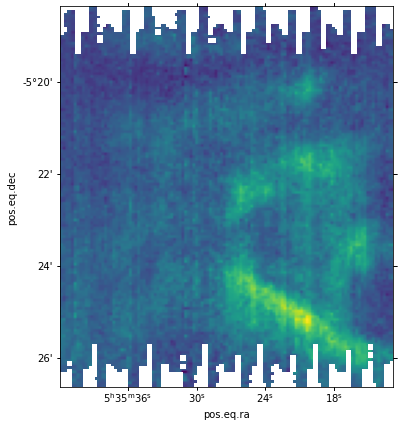

In [145]:
ax0 = plt.subplot(projection=data.target_wcs.celestial)
im0 = ax0.imshow(data.gridded_map[7700])


for info on the cygrid parameters check out *https://arxiv.org/pdf/1604.06667.pdf*